In [ ]:
!pip list

### Installing Dependencies and Importing them

In [1]:
# !pip install opencv-python matplotlib imageio gdown tensorflow

In [3]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

#### To use our GPU

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

In [6]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    # Standard normalization for a mean of zero and a standard deviation of one.
    return tf.cast((frames - mean), tf.float32) / std

In [8]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [9]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

print(f"The vocabulary is: {char_to_num.get_vocabulary()} "f"(size ={char_to_num.vocabulary_size()})")

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [10]:
def load_alignments(path:str) -> List[str]:
    with open(path, "r") as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens, " ", line[2]]
            
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding="UTF-8"), shape=[-1]))

In [11]:
tf.version

<module 'tensorflow._api.v2.version' from '/opt/conda/lib/python3.10/site-packages/tensorflow/_api/v2/version/__init__.py'>

In [12]:
def load_data(path:str):
    path  = bytes.decode(path.numpy())
    
    file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join("/kaggle/input/lipnet-dataset/data",'s1',f'{file_name}.mpg')
    alignment_path = os.path.join('/kaggle/input/lipnet-dataset/data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [13]:
test_path = '/kaggle/input/lipnet-dataset/data/s1/bbal6n.mpg'

In [14]:
frames , alignments = load_data(tf.convert_to_tensor(test_path))

In [15]:
frames.shape ,alignments.shape

(TensorShape([75, 46, 140, 1]), TensorShape([22]))

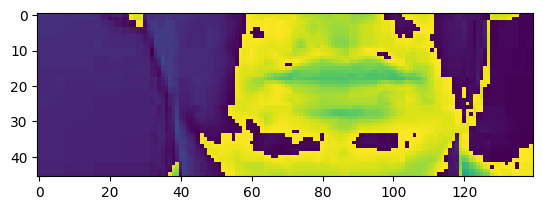

In [21]:
plt.imshow(frames[0])

In [22]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b' bin blue at l six now'>

In [23]:
def mappable_function(path:str) -> List[str]:
    result = tf.py_function(load_data,[path],(tf.float32,tf.int64))
    return result

### Creating Data Pipeline

In [24]:
data = tf.data.Dataset.list_files("/kaggle/input/lipnet-dataset/data/s1/*.mpg")
data = data.shuffle(500, reshuffle_each_iteration = False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))    # lenght of each alignmets is going to be diffrent so we have padded it to make its lengh same for all 
data = data.prefetch(tf.data.AUTOTUNE)    # prefetchs data batches asynchronously during model training

train = data.take(450)
test = data.skip(450)

In [25]:
len(test)

50

In [26]:
frames, alignments = data.as_numpy_iterator().next()

In [27]:
len(frames)   ## now we have 2 videos in each batch

2

In [28]:
testx = data.as_numpy_iterator()

In [31]:
val = testx.next(); val[0]

array([[[[[ 1.5360624 ],
          [ 1.4985974 ],
          [ 1.6484572 ],
          ...,
          [ 0.1123948 ],
          [ 0.37464935],
          [ 0.37464935]],

         [[ 1.5735272 ],
          [ 1.4985974 ],
          [ 1.6484572 ],
          ...,
          [ 0.14985974],
          [ 0.4495792 ],
          [ 0.4121143 ]],

         [[ 1.3862026 ],
          [ 1.3862026 ],
          [ 1.4236676 ],
          ...,
          [ 0.2247896 ],
          [ 0.29971948],
          [ 0.29971948]],

         ...,

         [[ 1.0864831 ],
          [ 1.0490181 ],
          [ 1.0490181 ],
          ...,
          [ 0.14985974],
          [ 0.1123948 ],
          [ 0.1123948 ]],

         [[ 1.0490181 ],
          [ 1.0490181 ],
          [ 1.0490181 ],
          ...,
          [ 0.1123948 ],
          [ 0.1123948 ],
          [ 0.07492987]],

         [[ 1.0490181 ],
          [ 1.0490181 ],
          [ 1.0490181 ],
          ...,
          [ 0.07492987],
          [ 0.07492987],
          

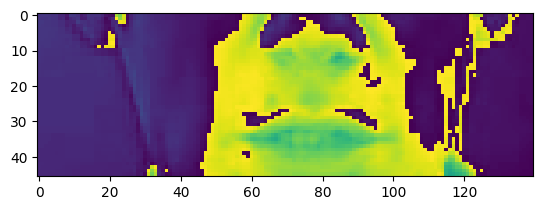

In [32]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][24])

In [33]:
directory = '/kaggle/working/animations'

if not os.path.exists(directory):
    os.makedirs(directory)
    print(f"Directory '{directory}' created successfully.")
else:
    print(f"Directory '{directory}' already exists.")

Directory '/kaggle/working/animations' created successfully.


In [34]:
video_frames = val[0][1]

# Ensure frames are in the correct shape and format for an animation
video_frames = np.squeeze(video_frames)

num_frames, height, width = video_frames.shape
video_frames_uint8 = (video_frames * 255).astype(np.uint8)
video_frames_reshaped = np.reshape(video_frames_uint8, (num_frames, height, width))

output_path = "/kaggle/working/animations/animation.gif"
imageio.mimsave('/kaggle/working/animations/animation.gif', video_frames_reshaped, fps=10)

print(f"Animation saved successfully to: {output_path}")

Animation saved successfully to: /kaggle/working/animations/animation.gif


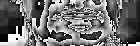

In [38]:
from IPython.display import Image

# Specify the path to the saved GIF
gif_path = '/kaggle/working/animations/animation.gif'

# Display the GIF
Image(filename=gif_path, width=400, height=300 , )

In [39]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b' set green with x four please'>

### Designing the Deep Neural Netwok

In [40]:
# pip install --upgrade tensorflow 

In [41]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [42]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [44]:
model = Sequential()
model.add(Conv3D(128, (3, 3, 3), input_shape=(75, 40, 140, 1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(256, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(75, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))


# model.add(TimeDistributed(Flatten()))
model.add(Reshape(( 75, -1)))

model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer="he_normal", activation="softmax"))

# model.add(Dense(char_to_num.vocabulary_size() + 1, kernel_initializer="he_normal", activation="softmax"))

In [45]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_3 (Conv3D)               │ (None, 75, 40, 140,    │         3,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 75, 40, 140,    │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 75, 20, 70,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 75, 20, 70,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 75, 20, 70,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 75, 10, 35,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 75, 10, 35, 75) │       518,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 75, 10, 35, 75) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_5 (MaxPooling3D)  │ (None, 75, 5, 17, 75)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 75, 6375)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 75, 256)        │     6,660,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 75, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 75, 41)         │        10,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,471,924 (32.32 MB)

 Trainable params: 8,471,924 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

Model architecture from the LipNet paper
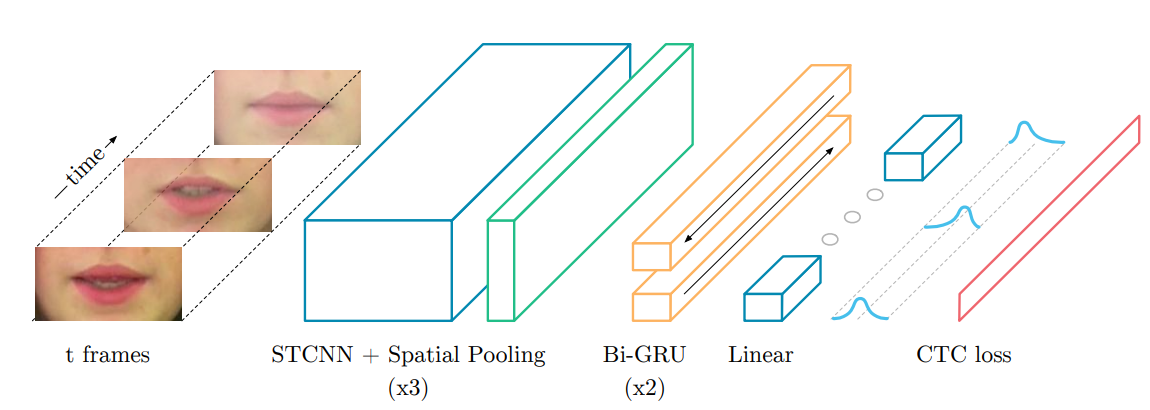
I have used BidirectionalLSTM instead of Bi-GRU

In [46]:
yhat = model.predict(val[0])
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[1]])

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


<tf.Tensor: shape=(), dtype=string, numpy=b'22222222222222222222222222222222222222222222222222222222222222222222222zzzz'>

In [47]:
model.input_shape, model.output_shape

((None, 75, 40, 140, 1), (None, 75, 41))

### Seting up Traing options and Train the Model

In [48]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [49]:
def CTC_loss(y_true, y_pred): #https://keras.io/examples/audio/ctc_asr/
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
    
    input_length = input_length * tf.ones(shape=(batch_len,1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len,1), dtype="int64")
    
    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [50]:
class produce_example(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))




# class ProduceExampleCallback(tf.keras.callbacks.Callback):
#     def __init__(self, dataset):
#         super(ProduceExampleCallback, self).__init__()
#         self.dataset = dataset  # Assuming `dataset` is a TensorFlow dataset object

#     def on_epoch_end(self, epoch, logs=None):
#         # Get a batch of data from the dataset
#         data = next(iter(self.dataset.batch(1)))

#         inputs, targets = data[0], data[1]

#         # Make predictions using the model
#         predictions = self.model.predict(inputs)

#         # Decode predictions and targets to text
#         decoded_targets = tf.strings.reduce_join([vocab[word] + " " for word in targets[0]]).numpy().decode('utf-8')
#         decoded_predictions = tf.strings.reduce_join([vocab[word] + " " for word in predictions[0]]).numpy().decode('utf-8')

#         # Print original and predicted text
#         print(f"Original: {decoded_targets}")
#         print(f"Prediction: {decoded_predictions}")
#         print("-" * 50)

In [51]:
# from tensorflow.keras.optimizers.legacy import Adam

In [52]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTC_loss)

In [54]:
!mkdir models

mkdir: cannot create directory 'models': File exists


In [55]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint.weights.h5'), monitor='loss', save_weights_only=True)

In [56]:
schedule_callback = LearningRateScheduler(scheduler)

In [57]:
example_callback = produce_example(test)

In [59]:
# url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
# output = 'checkpoints.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('checkpoints.zip', 'models')

checkpoint_path = '/kaggle/input/lipnet-model-checkpoint-74/tensorflow2/default/1/checkpoint.weights.h5'
model.load_weights(checkpoint_path)
# The model used here is trained till 74 epochs in the earlier versions of my notebook

# Optionally, print model summary to inspect the loaded model architecture
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_3 (Conv3D)               │ (None, 75, 40, 140,    │         3,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 75, 40, 140,    │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 75, 20, 70,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 75, 20, 70,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 75, 20, 70,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 75, 10, 35,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 75, 10, 35, 75) │       518,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 75, 10, 35, 75) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_5 (MaxPooling3D)  │ (None, 75, 5, 17, 75)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 75, 6375)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 75, 256)        │     6,660,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 75, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 75, 41)         │        10,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,471,924 (32.32 MB)

 Trainable params: 8,471,924 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
# model.load_weights('/kaggle/input/lipnet-model-checkpoints-55/tensorflow2/default/1/models/checkpoint')
# model.summary()

In [61]:
model.fit(train,validation_data = test, epochs=5, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/5


I0000 00:00:1724572221.775423     103 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


266/450 ━━━━━━━━━━━━━━━━━━━━ 2:13 725ms/step - loss: 1.3445

[mpeg1video @ 0x7bf81c075b00] ac-tex damaged at 22 17
[mpeg1video @ 0x7bf81c075b00] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 727ms/step - loss: 1.3212

[mpeg1video @ 0x7bf9a4095640] ac-tex damaged at 22 17
[mpeg1video @ 0x7bf9a4095640] Warning MVs not available
[mpeg1video @ 0x7bf99c0454c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7bf99c0454c0] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
Original:  lay red at r zero now
Prediction:  lay red at r zero now
Original:  set blue with o zero now
Prediction:  set blue with o zero now
450/450 ━━━━━━━━━━━━━━━━━━━━ 767s 2s/step - loss: 1.3210 - val_loss: 0.4011 - learning_rate: 1.0000e-04
Epoch 2/5
325/450 ━━━━━━━━━━━━━━━━━━━━ 1:29 720ms/step - loss: 1.2928

[mpeg1video @ 0x7bf88803a7c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7bf88803a7c0] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 718ms/step - loss: 1.2958

[mpeg1video @ 0x7bf99c067b00] ac-tex damaged at 22 17
[mpeg1video @ 0x7bf99c067b00] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Original:  place red with q three soon
Prediction:  place red with q thre son
Original:  set red at u three soon
Prediction:  set red at u thre son
450/450 ━━━━━━━━━━━━━━━━━━━━ 550s 1s/step - loss: 1.2958 - val_loss: 0.5009 - learning_rate: 1.0000e-04
Epoch 3/5
217/450 ━━━━━━━━━━━━━━━━━━━━ 2:48 722ms/step - loss: 1.1705

[mpeg1video @ 0x7bf83c087200] ac-tex damaged at 22 17
[mpeg1video @ 0x7bf83c087200] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 722ms/step - loss: 1.1427

[mpeg1video @ 0x7bf888001e00] ac-tex damaged at 22 17
[mpeg1video @ 0x7bf888001e00] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Original:  bin blue with s nine soon
Prediction:  bin blue with s nine son
Original:  set blue by n eight sp please
Prediction:  set blue by n eight sp please
450/450 ━━━━━━━━━━━━━━━━━━━━ 552s 1s/step - loss: 1.1428 - val_loss: 0.5036 - learning_rate: 1.0000e-04
Epoch 4/5
 79/450 ━━━━━━━━━━━━━━━━━━━━ 4:24 714ms/step - loss: 1.2629

[mpeg1video @ 0x58b6e9957200] ac-tex damaged at 22 17
[mpeg1video @ 0x58b6e9957200] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 714ms/step - loss: 1.2796

[mpeg1video @ 0x7bf834064f80] ac-tex damaged at 22 17
[mpeg1video @ 0x7bf834064f80] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Original:  bin green in t five soon
Prediction:  bin gren in t five son
Original:  set red at n eight now
Prediction:  set red at n eight now
450/450 ━━━━━━━━━━━━━━━━━━━━ 544s 1s/step - loss: 1.2794 - val_loss: 0.4066 - learning_rate: 1.0000e-04
Epoch 5/5
 96/450 ━━━━━━━━━━━━━━━━━━━━ 4:11 711ms/step - loss: 1.2090

[mpeg1video @ 0x7bf8d0070b00] ac-tex damaged at 22 17
[mpeg1video @ 0x7bf8d0070b00] Warning MVs not available


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 710ms/step - loss: 1.2756

[mpeg1video @ 0x7bf9a4015000] ac-tex damaged at 22 17
[mpeg1video @ 0x7bf9a4015000] Warning MVs not available


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Original:  place green at k five again
Prediction:  place gren at k five again
Original:  bin white with h two now
Prediction:  bin white with h two now
450/450 ━━━━━━━━━━━━━━━━━━━━ 541s 1s/step - loss: 1.2757 - val_loss: 0.4168 - learning_rate: 1.0000e-04


### Testing the model

In [62]:
test_data = test.as_numpy_iterator()
sample = test_data.next()

[mpeg1video @ 0x7bf851a2eec0] ac-tex damaged at 22 17
[mpeg1video @ 0x7bf851a2eec0] Warning MVs not available


In [63]:
yhat = model.predict(sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


In [64]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b' set white by v two now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b' place blue by p two now'>]

In [65]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [66]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b' set white by v two now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b' place blue by p two now'>]

#### testing on a video

In [67]:
sample = load_data(tf.convert_to_tensor('/kaggle/input/lipnet/LipNet/s1/bbal6n.mpg'))

In [68]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b' bin blue at l six now'>]

In [69]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [70]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [71]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b' bin blue at l six now'>]